In [1]:
import numpy as np
import pandas as pd
import yaml
import os
import matplotlib.pyplot as plt

In [2]:
def load_yaml_exp(f):
    with open(f) as file:
        expdict = yaml.load(file, Loader=yaml.FullLoader)
    return expdict

In [3]:
def process_output_dir(directory):
    res_arr = []
    for entry in os.scandir(directory):
        if entry.path.endswith(".yaml"):
            try:
                history = load_yaml_exp(entry.path)
                name = os.path.splitext(os.path.basename(entry.path))[0]
                history['name'] = name
                summarize_diagnostics(history, name)
                res_arr.append(history)
            except Exception as err:
                print(f'Error for file {entry.path}: {err}')
    return res_arr

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history, filename):
    # plot loss
    plt.subplot(211)
    plt.title(f'{history["name"]}: Cross Entropy Loss')
    plt.plot(history['loss'], color='blue', label='train')
    plt.plot(history['val_loss'], color='orange', label='valid')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history['accuracy'], color='blue', label='train')
    plt.plot(history['val_accuracy'], color='orange', label='valid')
    # save plot to file
    plt.legend()
    plt.savefig(f'output/graphs/argon_{filename}_plot.png')
    plt.close()

In [5]:
history = process_output_dir('argon/output/')

<Figure size 432x288 with 0 Axes>

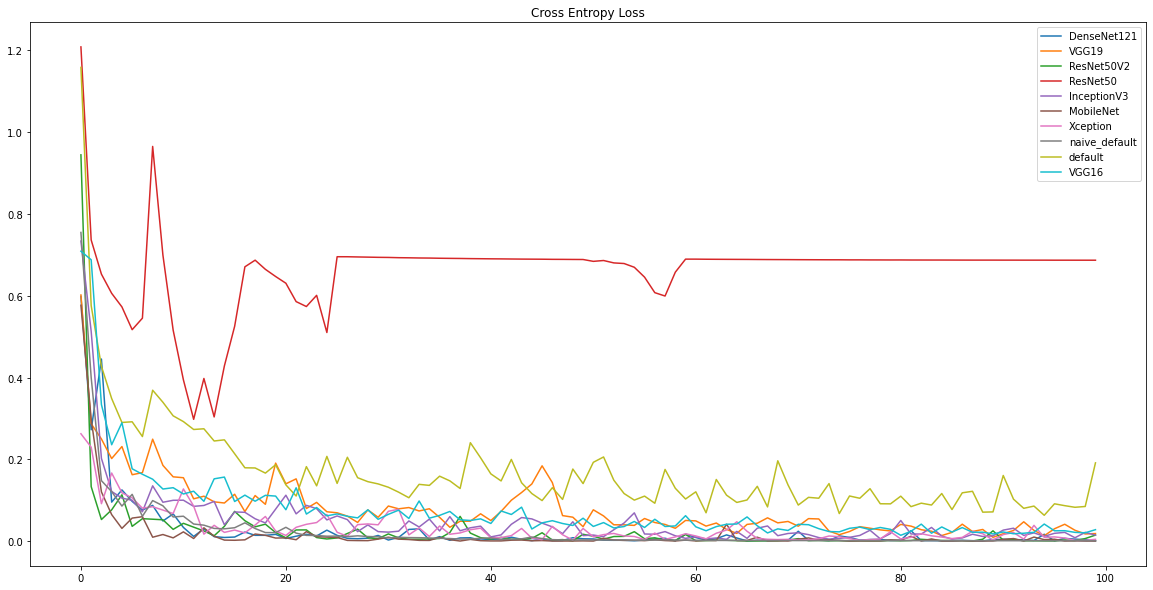

In [6]:
plt.clf()
plt.figure(figsize=(20,10))
plt.title('Cross Entropy Loss')
for h in history:
    plt.plot(h['loss'], label=h['name'])
plt.legend()
plt.savefig('output/graphs/full_loss_plot20.svg')

<Figure size 432x288 with 0 Axes>

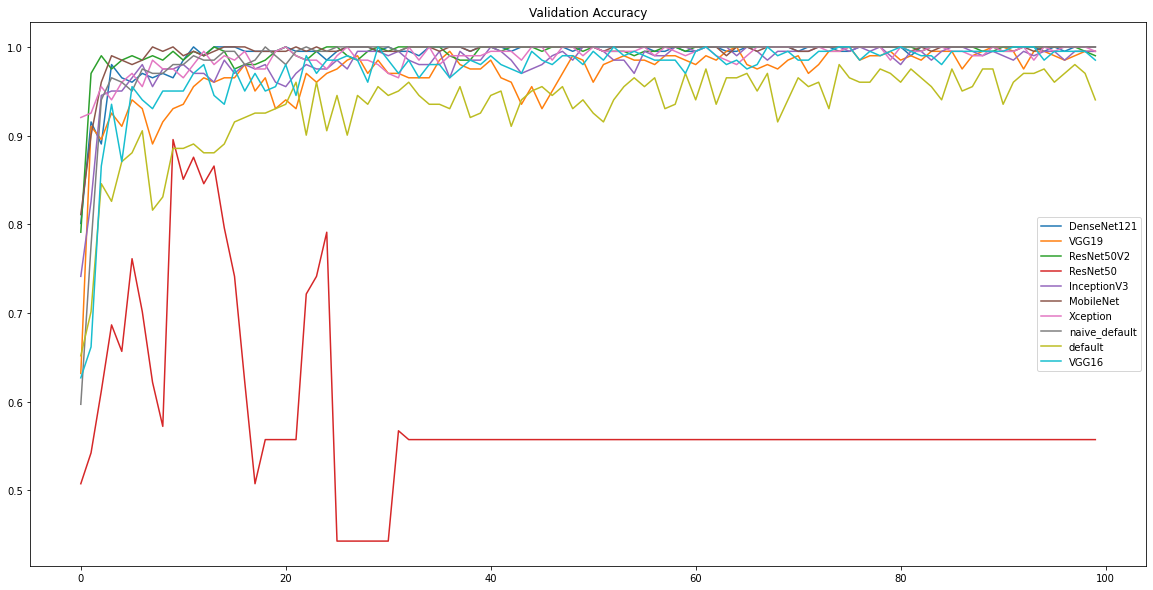

In [7]:
plt.clf()
plt.figure(figsize=(20,10))
plt.title('Validation Accuracy')
for h in history:
    plt.plot(h['accuracy'][0:100], label=h['name'])
plt.legend()
plt.savefig('output/graphs/full_acc_plot90.svg')

<Figure size 432x288 with 0 Axes>

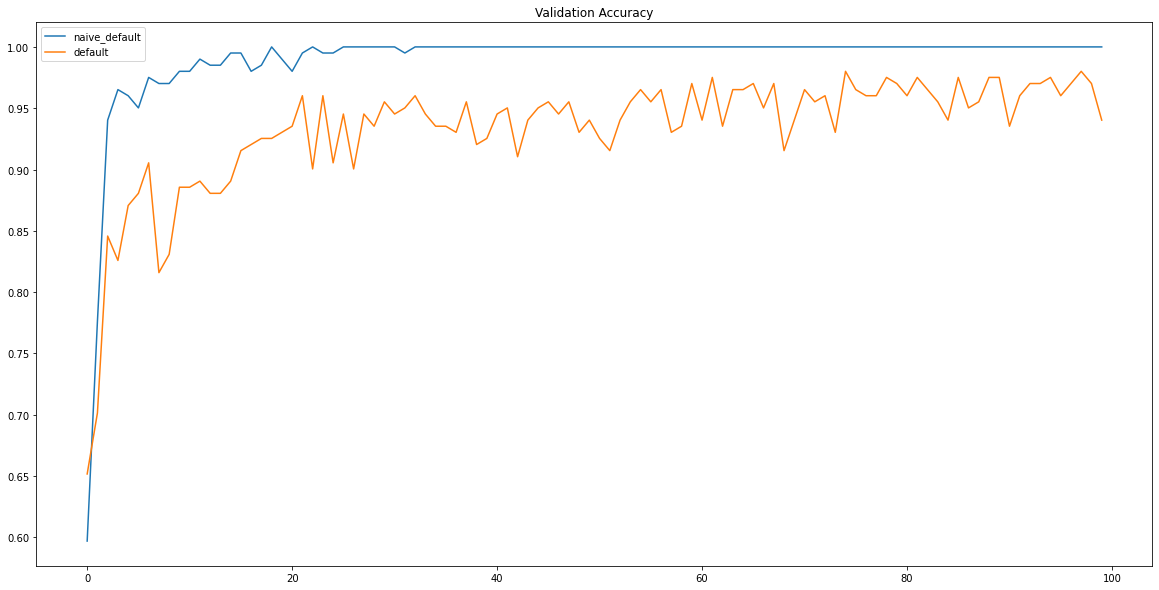

In [10]:
plt.clf()
plt.figure(figsize=(20,10))
plt.title('Validation Accuracy')
for h in history:
    if h['name'] == "default" or h['name'] == "naive_default":
        plt.plot(h['accuracy'][0:100], label=h['name'])
plt.legend()
plt.savefig('output/graphs/full_acc_plot90.svg')

In [11]:
for h in history:
    print(h['name'], h['test_accuracy'], np.argmax(h['val_accuracy']), np.max(h['val_accuracy']))

DenseNet121 0.9848484992980957 10 0.9800000190734863
VGG19 1.0 52 1.0
ResNet50V2 0.939393937587738 87 1.0
ResNet50 0.6060606241226196 8 0.8799999952316284
InceptionV3 0.9696969985961914 52 0.9399999976158142
MobileNet 1.0 4 1.0
Xception 0.9545454382896423 54 0.9800000190734863
naive_default 0.9545454382896423 8 0.9399999976158142
default 0.9848484992980957 43 0.9599999785423279
VGG16 1.0 70 1.0


In [12]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [13]:
IMAGE_SIZE = 200
def get_data():

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    test_generator = test_datagen.flow_from_directory(
        'data/test/',
        class_mode='binary', 
        batch_size=1,
        shuffle=False,
        target_size=(IMAGE_SIZE, IMAGE_SIZE))
    
    return test_generator

In [14]:
test_generator = get_data()

def eval_model(model_name, name):
    model = keras.models.load_model(model_name)
    y_hat = model.predict_generator(test_generator, steps=len(test_generator))
    
    y_true = []
    for f in test_generator.filenames:
        y_true.append(test_generator.class_indices[f.split('/')[0]])
    
    y_pred = []
    for i, val in enumerate(y_hat):
        y_pred.append(int(round(val[0])))
    
    confmat = confusion_matrix(y_true, y_pred)
    print(confmat)
    plot_confmat(confmat, name)
    
    print(accuracy_score(y_true, y_pred))
    print(test_generator.class_indices)
    print(classification_report(y_true, y_pred))
    return

Found 66 images belonging to 2 classes.


In [15]:
def plot_confmat(confmat, name):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(name)

    plt.tight_layout()
    plt.savefig(f'output/{name}-confusion.png', dpi=300)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    plt.show()
    return 

models/DenseNet121.h5
[[25  1]
 [ 0 40]]


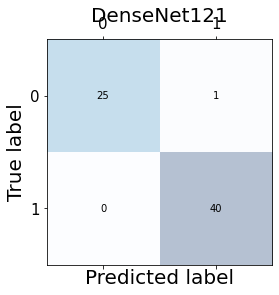

0.9848484848484849
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.98      1.00      0.99        40

    accuracy                           0.98        66
   macro avg       0.99      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66

models/ResNet50V2.h5
[[22  4]
 [ 0 40]]


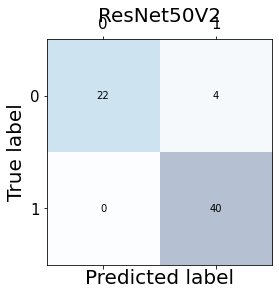

0.9393939393939394
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        26
           1       0.91      1.00      0.95        40

    accuracy                           0.94        66
   macro avg       0.95      0.92      0.93        66
weighted avg       0.94      0.94      0.94        66

models/VGG16.h5
[[26  0]
 [ 0 40]]


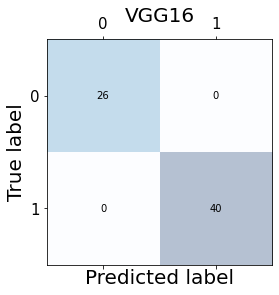

1.0
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        40

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

models/InceptionV3.h5
[[24  2]
 [ 0 40]]


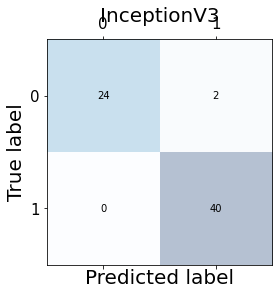

0.9696969696969697
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.95      1.00      0.98        40

    accuracy                           0.97        66
   macro avg       0.98      0.96      0.97        66
weighted avg       0.97      0.97      0.97        66

models/default.h5
[[26  0]
 [ 1 39]]


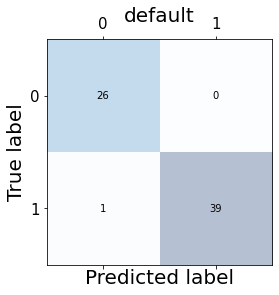

0.9848484848484849
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.97      0.99        40

    accuracy                           0.98        66
   macro avg       0.98      0.99      0.98        66
weighted avg       0.99      0.98      0.98        66

models/MobileNet.h5
[[26  0]
 [ 0 40]]


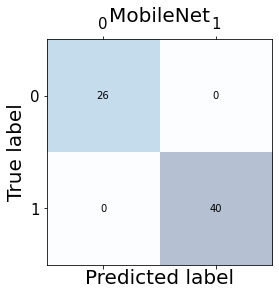

1.0
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        40

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

models/naive_default.h5
[[24  2]
 [ 1 39]]


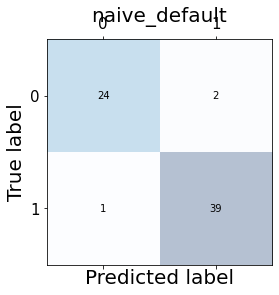

0.9545454545454546
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.95      0.97      0.96        40

    accuracy                           0.95        66
   macro avg       0.96      0.95      0.95        66
weighted avg       0.95      0.95      0.95        66

models/ResNet50.h5
[[ 0 26]
 [ 0 40]]


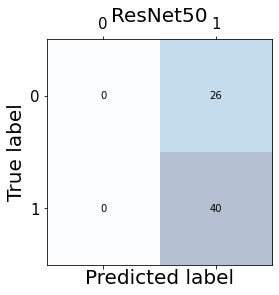

0.6060606060606061
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.61      1.00      0.75        40

    accuracy                           0.61        66
   macro avg       0.30      0.50      0.38        66
weighted avg       0.37      0.61      0.46        66

models/Xception.h5
[[23  3]
 [ 0 40]]


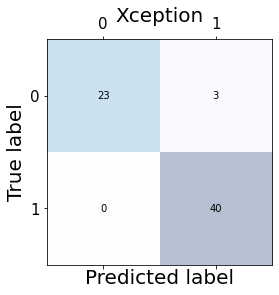

0.9545454545454546
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.93      1.00      0.96        40

    accuracy                           0.95        66
   macro avg       0.97      0.94      0.95        66
weighted avg       0.96      0.95      0.95        66

models/VGG19.h5
[[26  0]
 [ 0 40]]


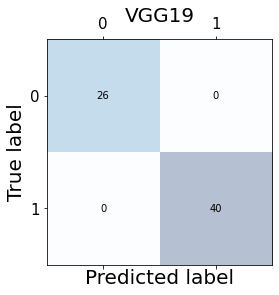

1.0
{'covid': 0, 'normal': 1}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        40

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



In [17]:
for entry in os.scandir('models/'):
    if entry.path.endswith(".h5"):
        print(entry.path)
        name = os.path.splitext(os.path.basename(entry.path))[0]
        eval_model(entry.path, name)

In [215]:
(500 % 100)

0

In [6]:
golden = load_yaml_exp('output_golden.yaml')

In [8]:
golden.keys()

dict_keys(['BATCH_SIZE', 'BIASBACKWARD', 'BIASFORWARD', 'END_EPOCH', 'ERROR_RATE', 'ID', 'LAYER', 'LOAD_EPOCH', 'LOCATION', 'LOSS', 'N_CLASSES', 'QUANTIZATION', 'TIME', 'TRIAL', 'WEIGHTBACKWARD', 'WEIGHTFORWARD', 'WEIGHTGRADIENT', 'end_valid_acc', 'epoch_lst', 'train_accuracy', 'train_losses', 'valid_accuracy', 'valid_losses'])

<Figure size 432x288 with 0 Axes>

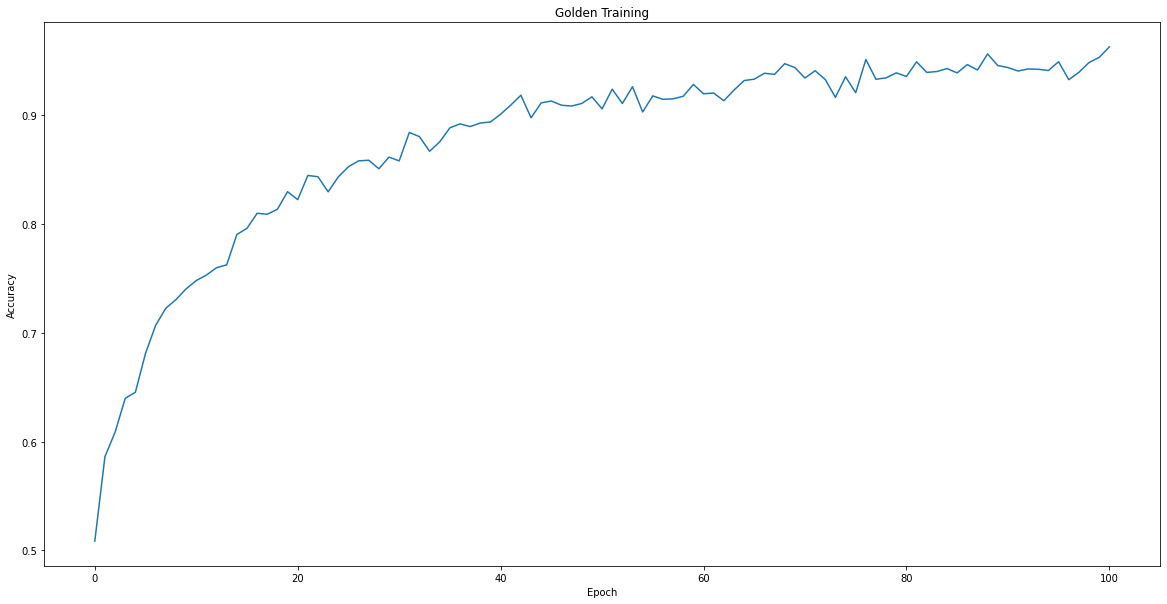

In [14]:
plt.clf()
plt.figure(figsize=(20,10))
plt.title('Golden Training')
plt.plot(golden['train_accuracy'], label='Train Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.savefig('dnn-golden.png')